In [ ]:
#same as the previous code but with 5 years data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data_NSE = pd.read_csv("NIFTY_50_5years.csv")
data_NYSE = pd.read_csv("NYSE_5Y.csv")

data_NSE["Date"] = pd.to_datetime(data_NSE["Date"], dayfirst=True)
data_NYSE['Date'] = pd.to_datetime(data_NYSE['Date'])

data_nse = data_NSE.sort_values('Date').reset_index(drop=True)
data_nyse = data_NYSE.sort_values('Date').reset_index(drop=True)

data_nse['Close'] = data_nse['Close'].astype(float)
data_nyse['Close'] = data_nyse['Close/Last'].astype(float)  # Use 'Close/Last' column for NYSE data

nse_returns = np.log(data_nse['Close']).diff().dropna().to_numpy()
nyse_returns = np.log(data_nyse['Close']).diff().dropna().to_numpy()


min_len = min(len(nse_returns),len(nyse_returns))
nse_returns = nse_returns[-min_len:]
nyse_returns = nyse_returns[-min_len:]

window_size = 5
X_cond,Y_target = [],[]

for i in range(window_size,len(nyse_returns)-1):
    X_cond.append(nyse_returns[i-window_size:i])
    Y_target.append(nse_returns[i+1])

X_cond = np.array(X_cond)
Y_target = np.array(Y_target)

scaler_x,scaler_y=StandardScaler(),StandardScaler()

X_cond_scaled = scaler_x.fit_transform(X_cond)
Y_target_scaled = scaler_y.fit_transform(Y_target.reshape(-1,1)).flatten()

# print(X_cond_scaled.shape,Y_target_scaled.shape)


In [5]:
from tensorflow.keras.layers import Input,Dense,Concatenate
from tensorflow.keras import Model

# DDPM-style denoiser with MLP layers:
def get_denoising_model(cond_dim,noise_dim=1,hidden_dim=64):
    noisy_input = Input(shape=(noise_dim,))
    cond_input = Input(shape=(cond_dim,))

    x = Concatenate()([noisy_input,cond_input])
    x = Dense(hidden_dim,activation="relu")(x)
    x = Dense(hidden_dim,activation="relu")(x)
    out = Dense(noise_dim)(x)

    return Model(inputs=[noisy_input,cond_input],outputs=out)

In [9]:
# Training for Conditional Denoising
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = get_denoising_model(cond_dim=5)

X_tensor = tf.convert_to_tensor(X_cond_scaled,dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_target_scaled.reshape(-1,1),dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((X_tensor, Y_tensor))
dataset = dataset.shuffle(buffer_size=512).batch(32) 

def map_to_conditional_inputs(condition, target):
    noise = tf.random.normal(shape=tf.shape(target))
    noisy_target = target+noise
    return (noisy_target, condition), noise

conditional_dataset = dataset.map(map_to_conditional_inputs)
conditional_dataset = conditional_dataset.prefetch(tf.data.AUTOTUNE)

model.compile(
    optimizer=Adam(0.001),
    loss=MeanSquaredError()
)

model.fit(conditional_dataset, epochs=1000)

Epoch 1/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - loss: 0.9206 
Epoch 2/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.4997
Epoch 3/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.4678
Epoch 4/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.4911
Epoch 5/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.5368
Epoch 6/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.5610
Epoch 7/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.4693
Epoch 8/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.5017
Epoch 9/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.5187
Epoch 10/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.5160
Epoch 11/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.4720
Epoch 12/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.4847
Epoch 13/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.4949
Epoch 14/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.4413
Epoch 15/1000
39/39 ━━━━━━━━

In [10]:
def sample_nse_return(x_cond_np, model):
    x_cond = tf.convert_to_tensor(x_cond_np, dtype=tf.float32)  # shape (1, 5)
    y_noisy = tf.random.normal(shape=(1, 1))
    epsilon_pred = model.predict([y_noisy, x_cond], verbose=0)
    y_denoised = y_noisy - epsilon_pred
    return y_denoised.numpy().flatten()


last_6_prices = data_nyse['Close'].to_numpy()[-6:]
# print(last_6_prices.shape)
last_5_returns = np.log(last_6_prices[1:] / last_6_prices[:-1]) 
# print(last_5_returns.shape)
x_cond_input_scaled = scaler_x.transform(last_5_returns.reshape(1, -1))  # shape: (1, 5)


n_samples = 1600
samples_scaled = np.array([sample_nse_return(x_cond_input_scaled, model) for _ in range(n_samples)])

# Inverse transform to get actual log returns
samples_real = scaler_y.inverse_transform(samples_scaled.reshape(-1, 1)).flatten()

# Get expected return and standard deviation
expected_return = np.mean(samples_real)
std_dev = np.std(samples_real)

# Convert to % price change
percent_change = (np.exp(expected_return) - 1) * 100

print("Predicted NSE log-return for 1 June 2025:", expected_return)
print("Standard deviation:", std_dev)
print("Expected % change in NSE on 1 June 2025:", percent_change, "%")



Predicted NSE log-return for 1 June 2025: -0.00078808813
Standard deviation: 0.003356904
Expected % change in NSE on 1 June 2025: -0.07877349853515625 %


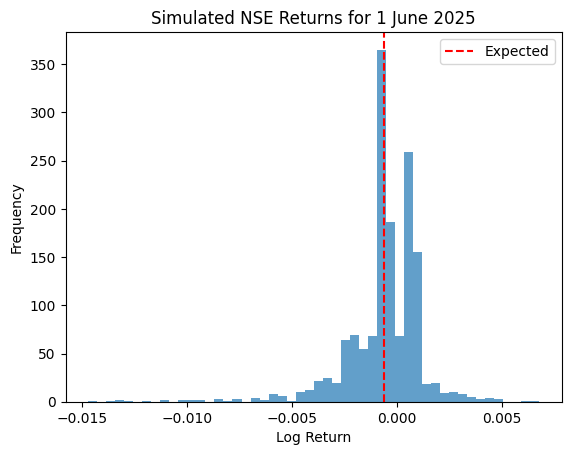

In [8]:
import matplotlib.pyplot as plt
plt.hist(samples_real, bins=50, alpha=0.7)
plt.title("Simulated NSE Returns for 1 June 2025")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.axvline(expected_return, color='r', linestyle='--', label='Expected')
plt.legend()
plt.show()


Epoch 1/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.9634 
Epoch 2/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.5972
Epoch 3/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.5281
Epoch 4/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.5595
Epoch 5/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 0.5525
Epoch 6/300
 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6649

c:\Users\Aditya Dwaraki Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.5619
Epoch 7/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.4697
Epoch 8/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.4625
Epoch 9/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.4833
Epoch 10/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.5165
Epoch 11/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.4968
Epoch 12/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.4730
Epoch 13/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.5188
Epoch 14/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.4706
Epoch 15/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.5636
Epoch 16/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.4846
Epoch 17/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.5228
Epoch 18/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.4747
Epoch 19/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.4895
Epoch 20/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/

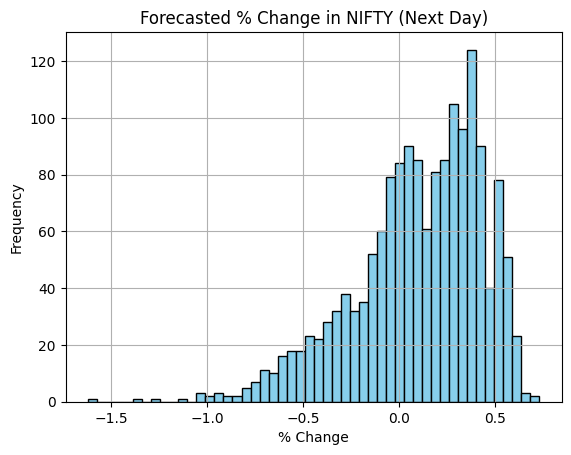

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ====== Load and Preprocess Data ======

# Load datasets
data_NSE = pd.read_csv("NIFTY_50_5years.csv")
data_NYSE = pd.read_csv("NYSE_5Y.csv")

# Rename Close column in NYSE data
data_NYSE.rename(columns={"Close/Last": "Close"}, inplace=True)

# Convert dates
data_NSE["Date"] = pd.to_datetime(data_NSE["Date"], format="%d %b %Y")
data_NYSE["Date"] = pd.to_datetime(data_NYSE["Date"], format="%m/%d/%Y")

# Sort by date
data_nse = data_NSE.sort_values("Date").reset_index(drop=True)
data_nyse = data_NYSE.sort_values("Date").reset_index(drop=True)

# Calculate log returns
nse_returns = np.log(data_nse['Close']).diff().dropna().to_numpy()
nyse_returns = np.log(data_nyse['Close']).diff().dropna().to_numpy()

# Align lengths
min_len = min(len(nse_returns), len(nyse_returns))
nse_returns = nse_returns[-min_len:]
nyse_returns = nyse_returns[-min_len:]

# ====== Create Windowed Dataset ======

window_size = 5
X_cond, Y_target = [], []

for i in range(window_size, len(nyse_returns) - 1):
    X_cond.append(nyse_returns[i-window_size:i])
    Y_target.append(nse_returns[i+1])

X_cond = np.array(X_cond)
Y_target = np.array(Y_target)

# Scale
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_cond_scaled = scaler_x.fit_transform(X_cond)
Y_target_scaled = scaler_y.fit_transform(Y_target.reshape(-1, 1)).flatten()

# ====== Define Denoising Model ======

def get_denoising_model(cond_dim, noise_dim=1, hidden_dim=64):
    noisy_input = Input(shape=(noise_dim,))
    cond_input = Input(shape=(cond_dim,))
    
    x = Concatenate()([noisy_input, cond_input])
    x = Dense(hidden_dim, activation="relu")(x)
    x = Dense(hidden_dim, activation="relu")(x)
    out = Dense(noise_dim)(x)
    
    return Model(inputs=[noisy_input, cond_input], outputs=out)

model = get_denoising_model(cond_dim=5)

# ====== Prepare Dataset for Training ======

X_tensor = tf.convert_to_tensor(X_cond_scaled, dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_target_scaled.reshape(-1, 1), dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((X_tensor, Y_tensor))
dataset = dataset.shuffle(buffer_size=512).batch(32)

def map_to_conditional_inputs(condition, target):
    noise = tf.random.normal(shape=tf.shape(target))
    noisy_target = target + noise
    return (noisy_target, condition), noise

conditional_dataset = dataset.map(map_to_conditional_inputs)
conditional_dataset = conditional_dataset.prefetch(tf.data.AUTOTUNE)

# ====== Train the Model ======

model.compile(
    optimizer=Adam(0.001),
    loss=MeanSquaredError()
)

early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

model.fit(conditional_dataset, epochs=300, callbacks=[early_stopping])

# ====== Sampling Function ======

def sample_nse_return(x_cond_np, model):
    x_cond = tf.convert_to_tensor(x_cond_np, dtype=tf.float32)
    y_noisy = tf.random.normal(shape=(1, 1))
    epsilon_pred = model.predict([y_noisy, x_cond], verbose=0)
    y_denoised = y_noisy - epsilon_pred
    return y_denoised.numpy().flatten()

# ====== Generate Forecast ======

last_6_prices = data_nyse['Close'].to_numpy()[-6:]
last_5_returns = np.log(last_6_prices[1:] / last_6_prices[:-1])
x_cond_input_scaled = scaler_x.transform(last_5_returns.reshape(1, -1))

n_samples = 1600
samples_scaled = np.array([sample_nse_return(x_cond_input_scaled, model) for _ in range(n_samples)])
samples_real = scaler_y.inverse_transform(samples_scaled.reshape(-1, 1)).flatten()

expected_return = np.mean(samples_real)
std_dev = np.std(samples_real)
percent_change = (np.exp(expected_return) - 1) * 100

print(f"Predicted NSE log-return for 1 June 2025: {expected_return:.8f}")
print(f"Standard deviation: {std_dev:.8f}")
print(f"Expected % change in NSE on 1 June 2025: {percent_change:.8f} %")


# ====== Optional: Histogram Plot ======

plt.hist((np.exp(samples_real) - 1) * 100, bins=50, color='skyblue', edgecolor='black')
plt.title("Forecasted % Change in NIFTY (Next Day)")
plt.xlabel("% Change")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
